In [2]:
import time
import re
import datetime as pydt
import pandas as pd
import numpy as np
%matplotlib inline

In [27]:
# Exp1. manually recorded voltage & battery stored in "voltage_battery.csv" 
vol_batt_df = pd.read_csv("voltage_battery.csv", error_bad_lines=False) 

time_offset = 12*3600 # time was recorded as 7:00:00 (pm)
date = '2016:08:01:'

time_to_ts = lambda t: time.mktime(time.strptime(str(t), "%Y:%m:%d:%H:%M:%S")) + time_offset    
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)
vol_batt_df['time'] = '2016:08:01:' + vol_batt_df['time'] 
vol_batt_df['ts'] = vol_batt_df['time'].apply(time_to_ts)
vol_batt_df['local_dt'] =  vol_batt_df['ts'].apply(ts_to_dt)

# voltage is measured in Volts
voltage_df = pd.DataFrame(data={'metadata_write_ts': vol_batt_df['ts'], 'ts': vol_batt_df['ts'], 'local_dt': vol_batt_df['local_dt'], 'voltage': vol_batt_df['voltage'] })
#df.to_csv('voltage.csv')
voltage_df

battery_df= pd.DataFrame(data={'metadata_write_ts': vol_batt_df['ts'], 'ts': vol_batt_df['ts'], 'local_dt': vol_batt_df['local_dt'], 'battery': vol_batt_df['battery_level'] })
#df.to_csv('batterylevel.csv')
battery_df[0:2]

,battery,local_dt,metadata_write_ts,ts
0,100,2016-08-01 19:18:30,1.470104e+09,1.470104e+09
1,93,2016-08-01 19:22:00,1.470105e+09,1.470105e+09


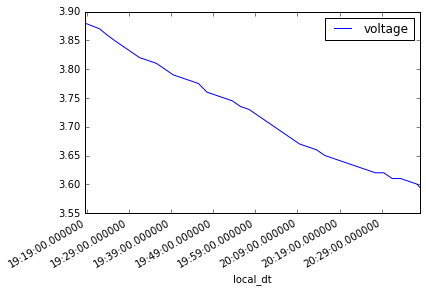

In [28]:
voltage_df.plot(x='local_dt', y='voltage')

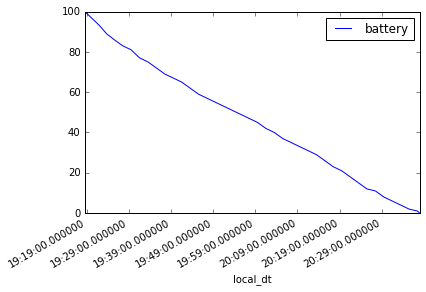

In [29]:
battery_df.plot(x='local_dt', y='battery')

2016:08:04:18:40:44
2016:08:04:21:05:01
sampling_period: 1.73730684327 seconds
   metadata_write_ts            ts  voltage                   local_dt
0       1.470361e+09  1.470361e+09     4.16 2016-08-04 18:40:44.000000
1       1.470361e+09  1.470361e+09     4.08 2016-08-04 18:40:45.737307


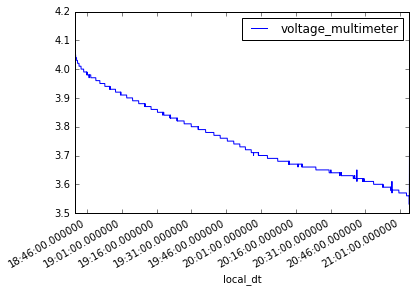

In [10]:
# Exp2. voltage recorded by the multimeter
df = pd.read_csv("voltage2.csv", error_bad_lines=False) 

start_time = df.start_time.iloc[0]
end_time = df.end_time.iloc[0]
print start_time
print end_time

direct_time_to_ts = lambda t: time.mktime(time.strptime(str(t), "%Y:%m:%d:%H:%M:%S"))  
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

start_ts = direct_time_to_ts(start_time)
end_ts = direct_time_to_ts(end_time)

n = len(df.voltage)
sampling_period = (end_ts - start_ts)/(n-1) #in seconds 
print 'sampling_period: ' + str(sampling_period) + ' seconds'

ts_list = np.arange(start_ts,end_ts+sampling_period*0.5,sampling_period)
#voltage is measured in V
voltage_df_multimeter = pd.DataFrame(data={'metadata_write_ts': ts_list, 'ts': ts_list, 'voltage': df.voltage })
voltage_df_multimeter['local_dt'] = voltage_df_multimeter.ts.apply(ts_to_dt)
#df.to_csv('voltage2.csv')
print voltage_df_multimeter[0:2]
voltage_df_multimeter.plot(x='local_dt', y='voltage', label='voltage_multimeter')

2016:08:05:12:24:55
2016:08:05:14:23:56
sampling_period: 1.74724736971 seconds
   current  metadata_write_ts            ts                   local_dt
0   0.0471       1.470425e+09  1.470425e+09 2016-08-05 12:24:55.000000
1   0.4800       1.470425e+09  1.470425e+09 2016-08-05 12:24:56.747247


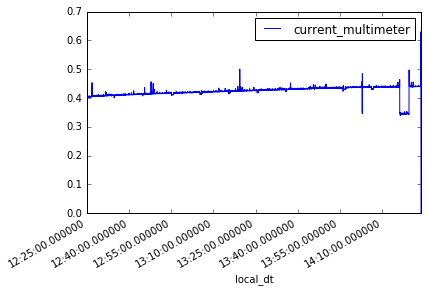

In [11]:
# Exp3. current recorded by the multimeter
df = pd.read_csv("current3.csv", error_bad_lines=False) 

start_time = df.start_time.iloc[0]
end_time = df.end_time.iloc[0]
print start_time
print end_time

direct_time_to_ts = lambda t: time.mktime(time.strptime(str(t), "%Y:%m:%d:%H:%M:%S"))  
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

start_ts = direct_time_to_ts(start_time)
end_ts = direct_time_to_ts(end_time)

n = len(df.current)
sampling_period = (end_ts - start_ts)/(n-1) #in seconds 
print 'sampling_period: ' + str(sampling_period) + ' seconds'

ts_list = np.arange(start_ts,end_ts+sampling_period*0.5,sampling_period)
#voltage is measured in V
current_df_multimeter = pd.DataFrame(data={'metadata_write_ts': ts_list, 'ts': ts_list, 'current': -df.current })
current_df_multimeter['local_dt'] = current_df_multimeter.ts.apply(ts_to_dt)
#df.to_csv('voltage2.csv')
print current_df_multimeter[0:2]
current_df_multimeter.plot(x='local_dt', y='current', label='current_multimeter')

11345.5608316


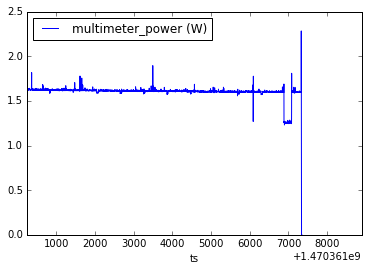

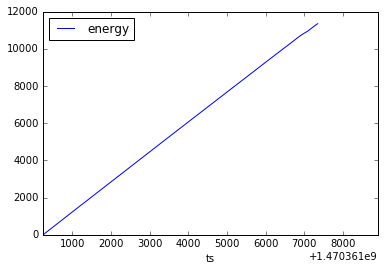

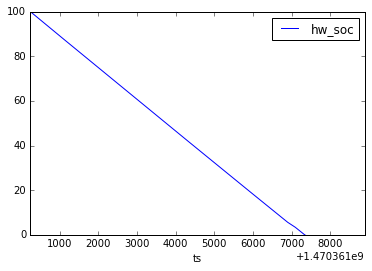

In [29]:
from scipy import integrate

power = voltage_df_multimeter.voltage * current_df_multimeter.current
power_df_multimeter = pd.DataFrame(data={'ts': voltage_df_multimeter.ts, 'power': power})
power_df_multimeter.plot(x='ts', y='power', label='multimeter_power (W)')

energy = integrate.cumtrapz(power_df_multimeter.power, power_df_multimeter.ts, initial=0)
energy_df_multimeter = pd.DataFrame(data={'ts': voltage_df_multimeter.ts, 'energy': energy})
energy_df_multimeter.plot(x='ts', y='energy')

max_cap = energy_df_multimeter.energy.max()
print max_cap
energy_df_multimeter['hw_soc'] = (max_cap - energy_df_multimeter.energy)/max_cap*100
energy_df_multimeter.plot(x='ts', y='hw_soc')

In [ ]:
energy_df.local_dt.iloc[0].hour
start_ts = min(battery_df.ts.iloc[0], energy_df.ts.iloc[0])
print 'battery: ' + str(ts_to_dt(battery_df.ts.iloc[0]))
print 'energy: ' + str(ts_to_dt(energy_df.ts.iloc[0]))
sw, = plt.plot((energy_df.ts-start_ts)/3600, interpolated_battery, label='SoC-sw')
hw, = plt.plot((energy_df.ts-start_ts)/3600, energy_df.soc, label='SoC-hw')

plt.legend(handles=[hw, sw])
plt.title('Comparison With HW-Based Measurements')
plt.xlabel('Hours')
plt.ylabel('Battery Percentage Level')
#fig.savefig('test.jpg')

soc_df = pd.DataFrame(data={'ts': energy_df.ts, 'sw': interpolated_battery, 'hw': energy_df.hw_soc})
diff = abs(soc_df.sw-soc_df.hw)/soc_df.hw*100
soc_df['diff']=diff
s = diff[:-1].sum(axis=0)
n = len(diff)-1
percent_error = s/n
print "avg soc % error: " + str(percent_error)
soc_df[0:3]

In [33]:
# Exp1. current recorded by the multimeter
df = pd.read_csv("current.csv", error_bad_lines=False) 

start_time = df.start_time.iloc[0]
end_time = df.end_time.iloc[0]
print start_time
print end_time

direct_time_to_ts = lambda t: time.mktime(time.strptime(str(t), "%Y:%m:%d:%H:%M:%S"))  
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

start_ts = direct_time_to_ts(start_time)
end_ts = direct_time_to_ts(end_time)

n = len(df.current)
sampling_period = (end_ts - start_ts)/(n-1) #in seconds 
print 'sampling_period: ' + str(sampling_period) + ' seconds'

ts_list = np.arange(start_ts,end_ts+sampling_period*0.5,sampling_period)
#current is measured in A
current_df = pd.DataFrame(data={'metadata_write_ts': ts_list, 'ts': ts_list, 'current': df.current })
current_df['local_dt'] = current_df.ts.apply(ts_to_dt)
#df.to_csv('current.csv')
current_df[:2]

2016:08:01:19:18:30
2016:08:01:20:46:14
sampling_period: 1.74709591769 seconds


,current,metadata_write_ts,ts,local_dt
0,0.449,1.470104e+09,1.470104e+09,2016-08-01 19:18:30.000000
1,0.462,1.470104e+09,1.470104e+09,2016-08-01 19:18:31.747096


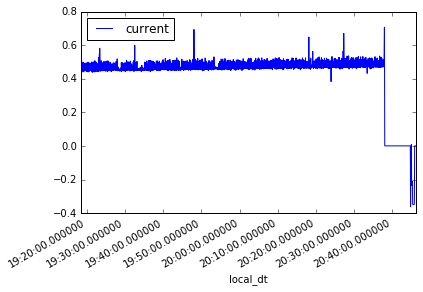

In [34]:
current_df.plot(x='local_dt', y='current')

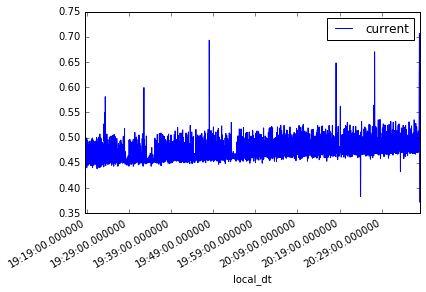

In [35]:
# removing current measurements taken after battery died
exp_end_ts = battery_df.ts.iloc[-1]
current_df = current_df[current_df.ts <= exp_end_ts]
current_df
current_df.plot(x='local_dt', y='current')

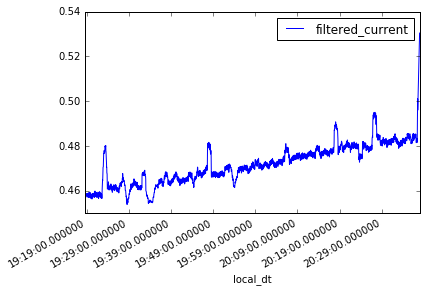

In [60]:
# current data smoothed out by Savitzky–Golay filter from *scipy*  import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

x = current_df.ts
y = current_df.current
yhat = savgol_filter(y, 31, 1) # window size 51, polynomial order 1
current_df['filtered_current'] = yhat
current_df.plot(x='local_dt', y='filtered_current')

2731
2731


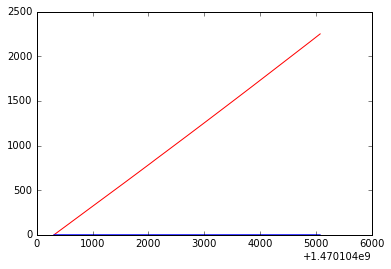

In [61]:
# test: integrate current over time using trapezoidal rule
from scipy import integrate
x = current_df.ts
y = current_df.current
print len(y)
y_int = integrate.cumtrapz(y, x, initial=0)
print len(y_int)
plt.plot(x, y_int, 'r-', x, y, 'b-')

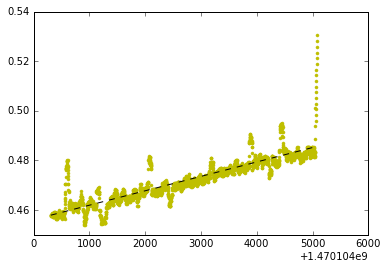

In [62]:
# test: fitting current data to a linear line
x = current_df.ts
y = current_df.smoothed_current
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'y.', x, fit_fn(x), '--k')
#plt.xlim(0, 5)
#plt.ylim(0, 12)

In [63]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

power_start_ts=2016-08-01 19:18:30
power_end_ts=2016-08-01 20:37:59.571598
477
477


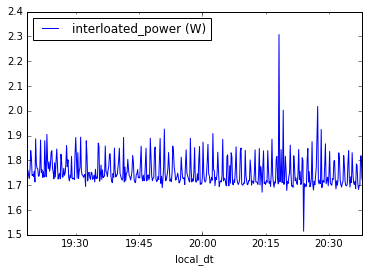

In [73]:
# interpolate voltage & current data then multiply to compute power 
power_start_ts = max(voltage_df.ts.iloc[0], current_df.ts.iloc[0])
power_end_ts = min(voltage_df.ts.iloc[-1], current_df.ts.iloc[-1])
dt1 = pydt.datetime.fromtimestamp(power_start_ts)
dt2 = pydt.datetime.fromtimestamp(power_end_ts)
print 'power_start_ts=' + str(dt1) + '\n' + 'power_end_ts=' + str(dt2)

xnew = np.arange(power_start_ts, power_end_ts, 10) # 1 minute
local_dt_new = map(pydt.datetime.fromtimestamp, xnew)

interpolated_voltage = get_interpolated(voltage_df.ts, voltage_df.voltage, xnew)
interpolated_current = get_interpolated(current_df.ts, current_df.current, xnew)
interpolated_battery = get_interpolated(battery_df.ts, battery_df.battery, xnew)

print len(interpolated_voltage)
print len(interpolated_current)
interpolated_power = interpolated_voltage * interpolated_current
power_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'power': interpolated_power})
power_df.plot(x='local_dt', y='power', label='interloated_power (W)')

(0, 5)

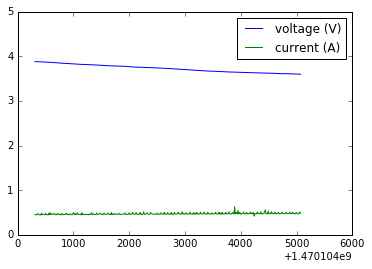

In [72]:
# plot interpolated voltage & current 
v, = plt.plot(xnew, interpolated_voltage, label='voltage (V)')
i, = plt.plot(xnew, interpolated_current, label='current (A)')
plt.legend(handles=[v, i])
plt.ylim(0, 5)

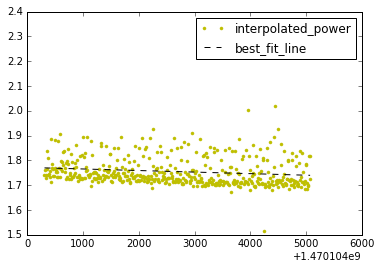

In [66]:
x = power_df.ts
y = power_df.power
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

p, = plt.plot(x,y, 'y.', label='interpolated_power')
f, = plt.plot(x, fit_fn(x), '--k', label='best_fit_line')

plt.legend(handles=[p, f])

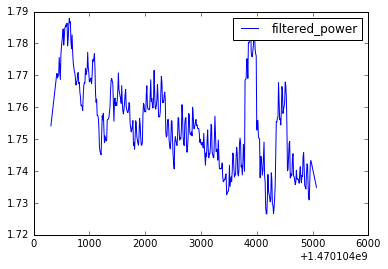

In [67]:
# power data smoothed out by Savitzky–Golay filter from *scipy*  
x = power_df.ts
y = power_df.power
yhat = savgol_filter(y, 21, 1) # window size 51, polynomial order 1
p, = plt.plot(x, yhat, label='filtered_power (W)')
plt.legend(handles=[p])

full discharge cycle: 4760.0 seconds


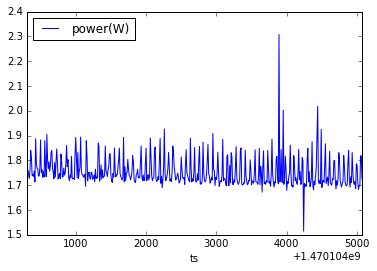

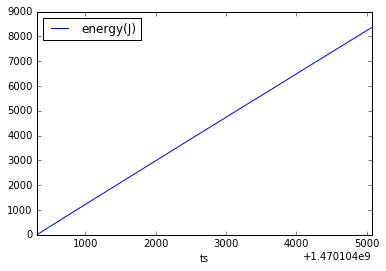

In [74]:
# integrate power to get energy 
from scipy import integrate

energy = integrate.cumtrapz(power_df.power, power_df.ts, initial=0)

#plt.plot(power, energy, 'r-')
#plt.plot(x, y, 'b-')

diff = x.iloc[-1] - x.iloc[0]
print 'full discharge cycle: ' + str(diff) + ' seconds'
energy_df = pd.DataFrame(data={'ts': power_df.ts, 'metadata_write_ts': power_df.ts, 'local_dt': power_df.local_dt, 'energy': energy})

power_df.plot(x='ts', y= 'power', label='power(W)')
energy_df.plot(x='ts', y= 'energy', label='energy(J)')

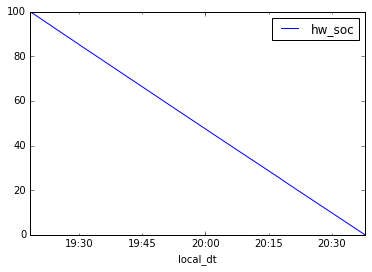

In [77]:
# calculate hw_soc from energy
max_cap = energy[-1]
energy_df['hw_soc'] = (max_cap - energy_df.energy)/max_cap*100
energy_df.plot(x='local_dt', y='hw_soc')

battery: 2016-08-01 19:18:30
energy: 2016-08-01 19:18:30
avg soc % error: 10.925045781


,hw,sw,ts,diff
0,100.000000,100.000000,1.470104e+09,0.000000
1,99.790319,99.666667,1.470104e+09,0.123912
2,99.580689,99.333333,1.470104e+09,0.248397


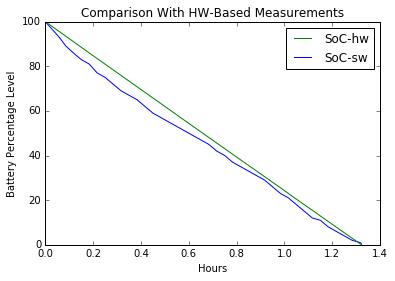

In [86]:
energy_df.local_dt.iloc[0].hour
start_ts = min(battery_df.ts.iloc[0], energy_df.ts.iloc[0])
print 'battery: ' + str(ts_to_dt(battery_df.ts.iloc[0]))
print 'energy: ' + str(ts_to_dt(energy_df.ts.iloc[0]))
sw, = plt.plot((energy_df.ts-start_ts)/3600, interpolated_battery, label='SoC-sw')
hw, = plt.plot((energy_df.ts-start_ts)/3600, energy_df.soc, label='SoC-hw')

plt.legend(handles=[hw, sw])
plt.title('Comparison With HW-Based Measurements')
plt.xlabel('Hours')
plt.ylabel('Battery Percentage Level')
#fig.savefig('test.jpg')

soc_df = pd.DataFrame(data={'ts': energy_df.ts, 'sw': interpolated_battery, 'hw': energy_df.hw_soc})
diff = abs(soc_df.sw-soc_df.hw)/soc_df.hw*100
soc_df['diff']=diff
s = diff[:-1].sum(axis=0)
n = len(diff)-1
percent_error = s/n
print "avg soc % error: " + str(percent_error)
soc_df[0:3]

-0.0201022407858
-0.998606000188
-0.0209981467495
-0.999997752109
-4.26659540208


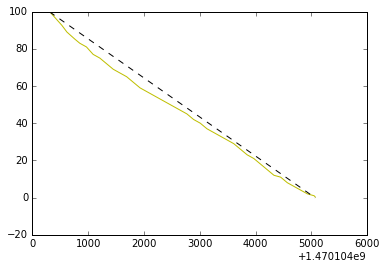

In [91]:
x = energy_df.ts
y = energy_df.soc
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

#plt.plot(x,y, 'y.', x, fit_fn(x), '--k')

x1 = energy_df.ts
y1 = interpolated_battery
fit1 = np.polyfit(x,y,1)
fit_fn1 = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x1,y1, 'y', x1, fit_fn1(x1), '--k')

from scipy import stats
slope1, intercept, r_value1, p_value, std_err = stats.linregress(x1, y1)
print slope1
print r_value1

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print slope
print r_value

print (slope1-slope)/slope*100

(0, 1.4)

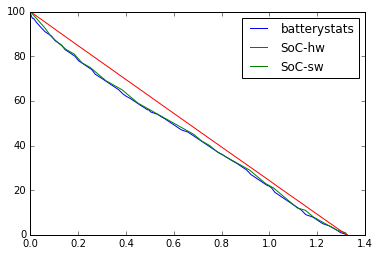

In [89]:
# compare with soc reported from the phone via batterystats 
battery_stats_df = pd.read_csv("batterylevel.csv", error_bad_lines=False) 
stats, = plt.plot((battery_stats_df.ts-start_ts)/3600, battery_stats_df.battery_level_pct, label='batterystats')
sw, = plt.plot((battery_df.ts-start_ts)/3600, battery_df.battery, label='SoC-sw')
hw, = plt.plot((energy_df.ts-start_ts)/3600, energy_df.soc, label='SoC-hw')
plt.legend(handles=[stats, hw, sw])
plt.xlim(0, 1.4)